# Horizon Extension model

In this notebook, we will go through the task of horizon extension for a single predicted horizon. The objective is to enlarge a horizon covered area.
In the previous notebooks with seismic horizon detection models such as [Carcass Interpolation](https://github.com/gazprom-neft/seismiqb/blob/master/models/Carcass%20interpolation/01_M_cube.ipynb) and 
[Inter-cube generalization](https://github.com/gazprom-neft/seismiqb/blob/master/models/Inter-cube%20generalization/01_Model.ipynb), you can see that sometimes predicted horizons contain holes. The size and quantity of such holes depend on the difficulty of the target horizon and the quality of the cube.  
This notebook describes a model that is trained to fill in these holes.

* [Task description](#Task-description)
* [Dataset](#Dataset)
* [Data preprocessing](#Data-preprocessing)
* [Model architecture](#Model-architecture)
* [Training](#Training)
* [Inference](#Inference)
* [Validation](#Validation)
* [Proposals for the improvement and further development](#Proposals-for-the-improvement-and-further-development)

# Task-description

Given a cube and a horizon with insufficient coverage we are going to train a model to extend this particular horizon.

We solve this task as a binary segmentation problem but unlike the [horizon detection model](https://github.com/gazprom-neft/seismiqb/blob/master/models/Inter-cube%20generalization/01_Model.ipynb) that sees only seismic images, the extension model also sees a part of a target-horizon.
Given incomplete information about the horizon of interest, the model can be trained to retrieve missing points on the horizon.

# Dataset

In [1]:
# Set the number of GPU-device
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [2]:
# some imports
import sys
import warnings
warnings.filterwarnings("ignore")

from copy import copy

import numpy as np
import torch.nn as nn
from tqdm.notebook import tqdm_notebook

sys.path.append('../../')

from seismiqb import *
from seismiqb.src.controllers.torch_models import ExtensionModel

from seismiqb.batchflow import FilesIndex, Pipeline
from seismiqb.batchflow import D, B, V, P, R, L

Load cube and a horizon with holes that could be predicted with one of the [horizon detection models](https://github.com/gazprom-neft/seismiqb/blob/master/models/Carcass%20interpolation/01_M_cube.ipynb).
You can find more information about dealing with seismic data and horizons in [our tutorials notebooks](https://github.com/gazprom-neft/seismiqb/tree/master/tutorials).

In [3]:
cube_path = "/notebooks/data/seismic/CUBE_2/M_cube.hdf5"
horizon_dir = '/PREDICTED_HORIZONS/PREDICTIONS_WITH_HOLES/*'

dataset = SeismicCubeset(FilesIndex(path=cube_path, no_ext=True))

dataset.load(horizon_dir)
dataset.modify_sampler(dst='train_sampler', finish=True)

Let's take a look at the depth map of the loaded horizon. White color corresponds to missing points on the horizon.

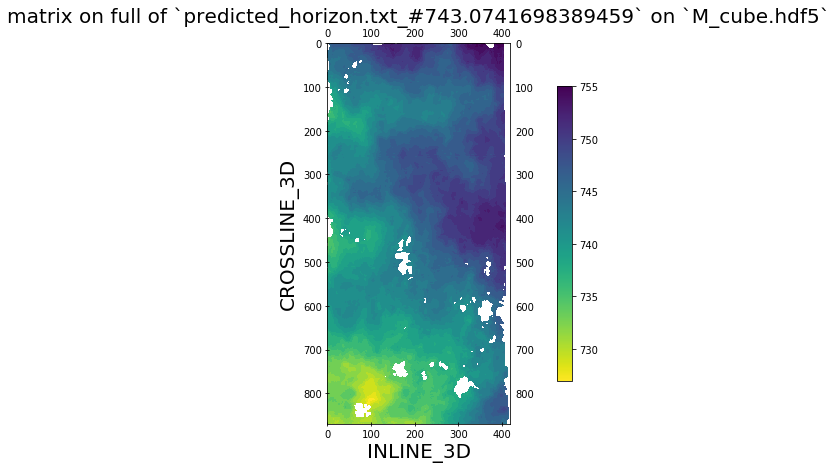

In [4]:
horizon = dataset.labels[0][0]
horizon.show()

We can also call `evaluate` method that computes simple horizon statistics like percentage of labeled traces, number of holes, and also computes support correlation metric that allows assessing horizon quality. To learn more about metrics check out [metrics notebook](https://github.com/gazprom-neft/seismiqb/blob/master/datasets/04_Horizon_metrics.ipynb). In short, the greener the better.


Number of labeled points:                         341500
Number of points inside borders:                  349193
Perimeter (length of borders):                    2920
Percentage of labeled non-bad traces:             0.9681653620768352
Percentage of labeled traces inside borders:      0.9779692032772708
Number of holes inside borders:                   65



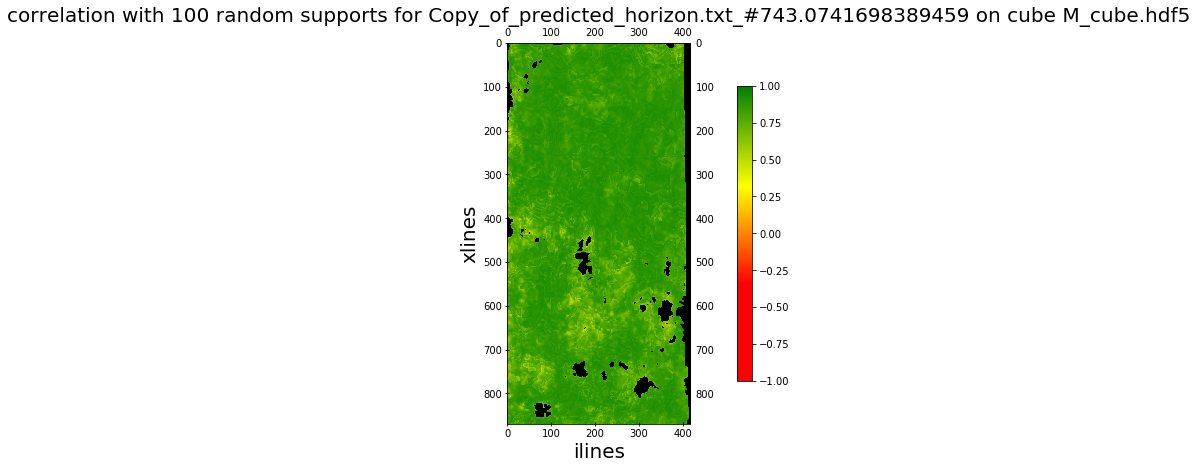

In [5]:
corrs = copy(horizon).evaluate(supports=100, plot=True)

# Data preprocessing

We train our models on 3D crops of fixed shape cut from the cube.

Let's define constants for batch size, crop shape and number of model training iterations.
We also define inference constants such as number of extension steps and stride size which will be explained in the inference section.

In [6]:
BATCH_SIZE = 64
CROP_SHAPE = (1, 64, 64)
NUM_ITERS = 300
N_STEPS = 8
STRIDE = 20

Let's define the load pipeline. It will
- sample BATCH_SIZE crops coordinate with `crop` action. Crops will be sampled in both xline and iline orientations (orientation depends on crop_shape, e.g, iline oriented crops have a shape (1, 64, 64) and xline crops - (64, 1, 64))
- create binary masks from the given horizon
- remove from the batch all crops that have less than 99 % horizon coverage using `mask_rebatch` with `threshold=0.8` because we don't want to use in training parts of the horizon that contain holes. Note that after this action actual batch size fed to the model will be less than `BATCH_SIZE`
- use the remaining crop coordinates load actual seismic data with `load_cubes`
- reshape crops of different orientations to the same shape by transposing xline oriented crops with `adaptive_reshape`
- normalize seismic data by dividing by 99 quantile of the data in the cube: this way, most of the data is in $[-1, 1]$ range

In [7]:
load = (Pipeline()
        .crop(points=D('train_sampler')(BATCH_SIZE),
              shape=CROP_SHAPE, side_view=True)
        .create_masks(dst='masks', width=3)
        .mask_rebatch(src='masks', threshold=0.8)
        .load_cubes(dst='images')
        .adaptive_reshape(src=['images', 'masks'],
                          shape=CROP_SHAPE)
        .scale(mode='q', src='images')
       )

To train a model to extend a specific horizon we have to provide some data about it to the model. We provide a part of a target mask as an input to our model.
To do so we partially zero out the loaded mask and leave 10-40 percent of it nonzero (depending on the size and the number of holes in the horizon).

Here we define a mask distortion pipeline that thins out the loaded mask and saves it into a new prior_mask-component of the batch.

In [8]:
def functor(scale):
    return lambda m: np.sin(m[:, 0] * scale)

distort = (Pipeline()
            .transpose(src='masks', order=(1, 2, 0))
            .filter_out(src='masks', dst='prior_masks',
                        expr=lambda m: m[:, 0],
                        low=P(R('uniform', low=0., high=0.4)),
                        length=P(R('uniform', low=0.30, high=0.5)))
            .transpose(src=['masks', 'prior_masks'], order=(2, 0, 1))
          )

Let's combine pipelines and take a look at the seismic data, the full mask that is our NN target, and the thinned out version of it that is fed to the model.

In [9]:
show_pipeline = (load + distort) << dataset
batch = show_pipeline.next_batch(1)

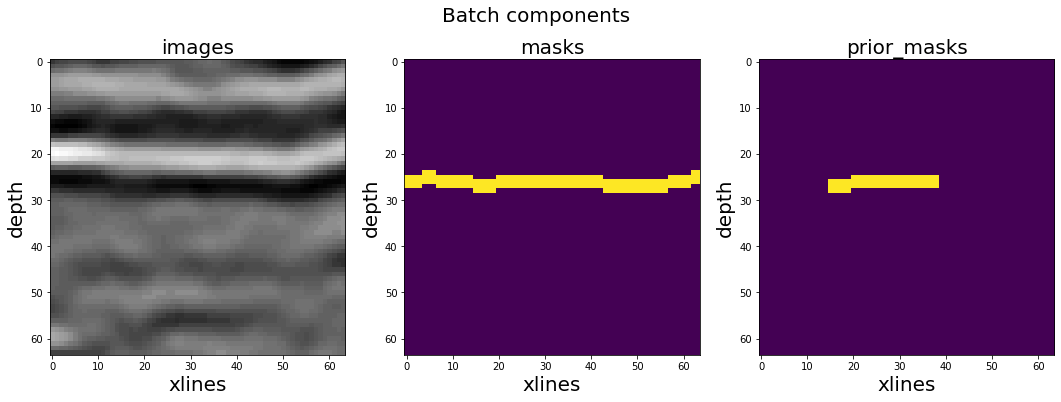

In [10]:
batch.plot_components('images', 'masks', 'prior_masks', idx=0, mode='separate')

We also define an augmentation pipeline with rotation on a random angle and random flip:

In [11]:
augment = (Pipeline()
            .transpose(src=['images', 'masks', 'prior_masks'], order=(1, 2, 0))
            .rotate(angle=P(R('uniform', -30, 30)),
                    src=['images', 'masks', 'prior_masks'], p=0.3)
            .flip(src=['images', 'masks', 'prior_masks'], axis=1, p=0.3)
            .transpose(src=['images', 'masks', 'prior_masks'], order=(2, 0, 1))
          )

# Model architecture

In previous cells we have created `prior_masks` component that is a thin-out copy of an actual `mask` component. Our idea is to provide a partial horizon to the model along with a seismic data and train model to restore it. 



We modify the traditional [EncoderDecoder](https://github.com/analysiscenter/batchflow/blob/master/batchflow/models/torch/encoder_decoder.py) architecture by an additional encoding branch with prior information about the horizon of interest. Information from this new branch is repeatedly incorporated into the main branch before each of the downsampling steps. 
For the sake of brevity, we don't provide model code in this notebook, but you can find our PyTorch implementation [here]().

<p align="center">
    <img src="images/architecture.png" alt="Drawing" />
</p>

Both encoder branches have a similar layout. We use 4 downsampling steps with ResNet blocks and increase the number of filters from 32 twice at each step.

We optimize the Dice loss using Adam optimizer with starting `learning rate = 1e-3` and exponential decay by `gamma=0.1` every 100 epochs.

In [ ]:
MODEL_CONFIG = {
    # Model layout
    'body/encoder': {
        'num_stages': 3,
        'order': 'sbd',
        'blocks': {
            'base': ResBlock,
            'n_reps': 1,
            'filters': [32, 64, 128],
            'attention': 'scse',
        },
    },
    'body/embedding': {
        'base': ResBlock,
        'n_reps': 1,
        'filters': 128,
        'attention': 'scse',
    },
    'body/decoder': {
        'num_stages': 3,
        'upsample': {
            'layout': 'tna',
            'kernel_size': 2,
        },
        'blocks': {
            'base': ResBlock,
            'filters': [128, 64, 32],
            'attention': 'scse',
        },
    },
    'output': 'sigmoid',
    # Train configuration
    'loss': 'bdice',
    'optimizer': {'name': 'Adam', 'lr': 0.001,},
    'decay': {'name': 'exp', 'gamma': 0.1, 'frequency': 150},
    }

# Training

Define pipeline that initializes a model with the model_config defined above and feeds seismic data, prior masks and true masks to the model:

In [ ]:
train_model = (Pipeline()
                .init_variable('loss_history', default=[])
                .init_model('dynamic', ExtensionModel, 'base', MODEL_CONFIG)
                .train_model('base', fetches='loss', save_to=V('loss_history', mode='a'),
                             images=B('images'),
                             prior_masks=B('prior_masks'),
                             masks=B('masks'))
                )

Combine all pipelines to one and feed actual dataset to it:

In [ ]:
training_pipeline = (load + distort + augment + train_model) << dataset

Run training pipeline for NUM_ITERS iterations and show loss function plot:

In [ ]:
training_pipeline.run(D('size'), n_iters=NUM_ITERS, bar='n')
plot_loss(training_pipeline.v('loss_history'), ylabel='', title='ExtensionModel')

# Inference

To fill in the holes in the initial horizon we have to generate crops coordinates next to them so that each crop contains a partial horizon that is used as an input to the trained model. After extracting predicted horizons and merging them to the initial one we repeat inference step with extended horizon boundaries.


First, we define an inference pipeline. It will:
- import trained model from the training pipeline
- get crop coordinates from `grid_gen` and load crops of seismic data in different orientations
- create a prior mask from the known horizon with holes
- reshape crops of different orientations to the same shape
- normalize seismic data
- feed seismic data and prior masks to the model and fetch predictions
- extract horizons from predictions and save them to pipeline variable `predicted_horizons`

In [17]:
inference_pipeline = (
    Pipeline()
    # Init everything
    .init_variable('predicted_horizons', default=list())
    .import_model('base', training_pipeline)

    # Load data
    .crop(points=L(D('grid_gen')), shape=L(D('shapes_gen')))
    .load_cubes(dst='images')
    .create_masks(dst='prior_masks', width=3)
    .adaptive_reshape(src=['images', 'prior_masks'],
                      shape=CROP_SHAPE)
    .scale(mode='q', src='images')

    # Use model for prediction
    .predict_model('base',
                   B('images'),
                   B('prior_masks'),
                   fetches='predictions',
                   save_to=B('predicted_masks', mode='w'))
    .transpose(src='predicted_masks', order=(1, 2, 0))
    .masks_to_horizons(src='predicted_masks', threshold=0.5, minsize=16,
                       order=L(D('orders_gen')), dst='horizons', skip_merge=True)
    .update(V('predicted_horizons', mode='e'), B('horizons'))) << dataset

As we could see previously, the horizon that we work with contains only a small amount of tiny holes; thus, we can set the number of performed extension steps to a small number.

In [18]:
initial_horizon = copy(dataset.labels[0][0])
prev_len = len(initial_horizon)

for _ in tqdm_notebook(range(N_STEPS)):

    # Create generator of crops locations near horizon boundaries
    dataset.make_extension_grid(dataset.indices[0],
                                crop_shape=CROP_SHAPE,
                                stride=STRIDE, # Overlap size of neighbouring crops
                                labels_src='labels',
                                batch_size=BATCH_SIZE * 4) # Prediction-time, we can enlarge batch size

    try:

        # Run inference pipeline for all generated crops
        for _ in range(dataset.grid_iters):
            inference_pipeline.next_batch(1, n_epochs=None)

    except TypeError:

        # No additional predicts
        break

    # Merge horizons extracted from predicted masks to the initial one
    horizons = [*inference_pipeline.v('predicted_horizons')]
    for hor in horizons:
        
        # Check if the horizon can be merged
        merge_code, _ = Horizon.verify_merge(dataset.labels[0][0], hor,
                                             mean_threshold=5.5, adjacency=5)

        # Merge
        if merge_code == 3:
            _ = dataset.labels[0][0].overlap_merge(hor, inplace=True)


    curr_len = len(dataset.labels[0][0])

    # Break if the length of extended area is too small
    if (curr_len - prev_len) < 5:
        break

    print(f'Extended from {prev_len} to {curr_len}, + {curr_len - prev_len}')
    prev_len = curr_len

Extended from 341500 to 351406, + 9906
Extended from 351406 to 351976, + 570
Extended from 351976 to 352082, + 106


# Validation

Let's call `evaluate` method for predicted horizon and see if we have actually extended our initial horizon.


Number of labeled points:                         352082
Number of points inside borders:                  352186
Perimeter (length of borders):                    2617
Percentage of labeled non-bad traces:             0.9981657306317314
Percentage of labeled traces inside borders:      0.9997047014929611
Number of holes inside borders:                   31



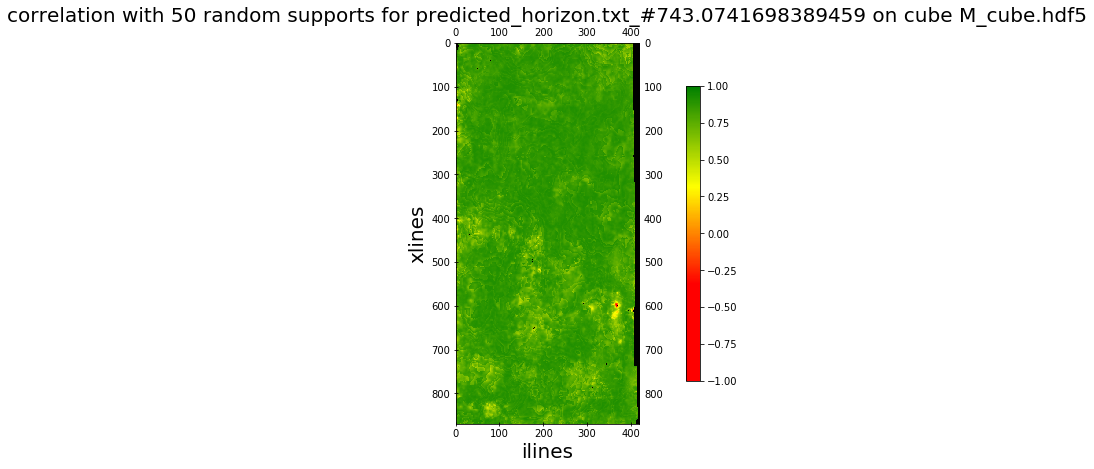

In [19]:
metrics = dataset.labels[0][0].evaluate()

The greener the better so we can say that extension procedure went well for all holes except tiny region around xline=590, iline=370.

Recall what we began with:


Number of labeled points:                         341500
Number of points inside borders:                  349193
Perimeter (length of borders):                    2920
Percentage of labeled non-bad traces:             0.9681653620768352
Percentage of labeled traces inside borders:      0.9779692032772708
Number of holes inside borders:                   65



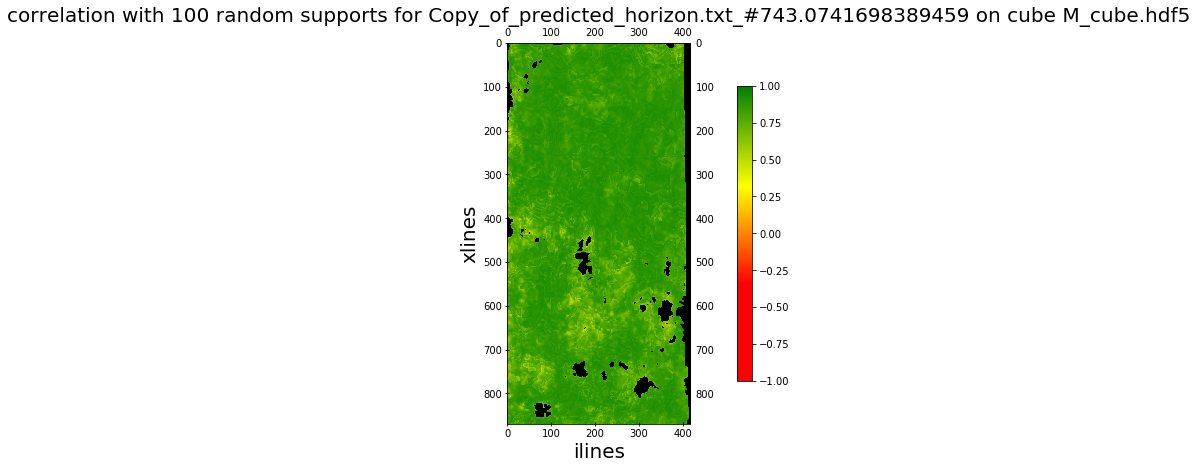

In [20]:
corrs = initial_horizon.evaluate(supports=100, plot=True)

So we have enlarged the percentage of labeled non-bad traces from 96.8 % to 99.8 %.

We can also take a look at the slides in the problematic region with horizons on it.

Initial horizon with holes at the xline oriented slide at iline=370:

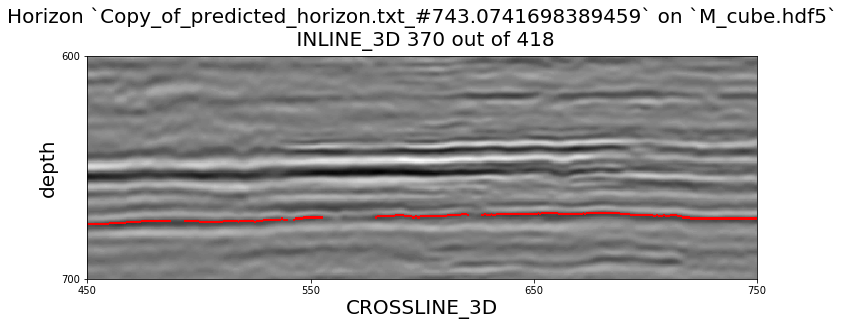

In [21]:
initial_horizon.show_slide(loc=370, width=2, zoom_slice=(slice(450, 850, None), slice(600, 800, None)))

Extended horizon at the xline oriented slide at iline=370:

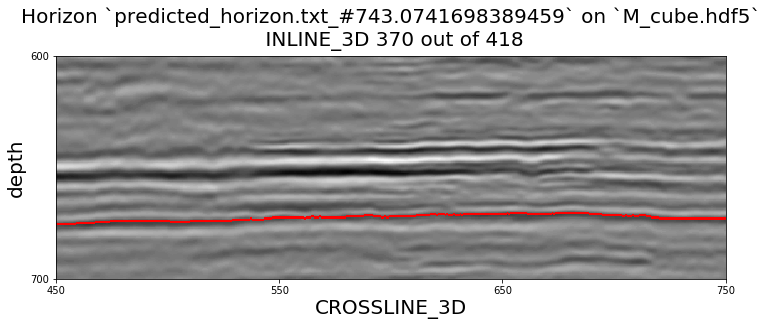

In [22]:
dataset.labels[0][0].show_slide(loc=370, width=2, zoom_slice=(slice(450, 850, None), slice(600, 800, None)))

It looks like the problems in the problematic region are not that bad so we can conclude that our extension procedure went well.

# Criticism

The horizon quality in the extended areas might be not satisfying enough and extended horizon may need some post-processing steps such as running through an [Enhancement]() model.

# Proposals for the improvement and further development

The proposed architecture might be not optimal and extensive research on different numbers of blocks, filters and combine operations between branches must be performed.